Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)


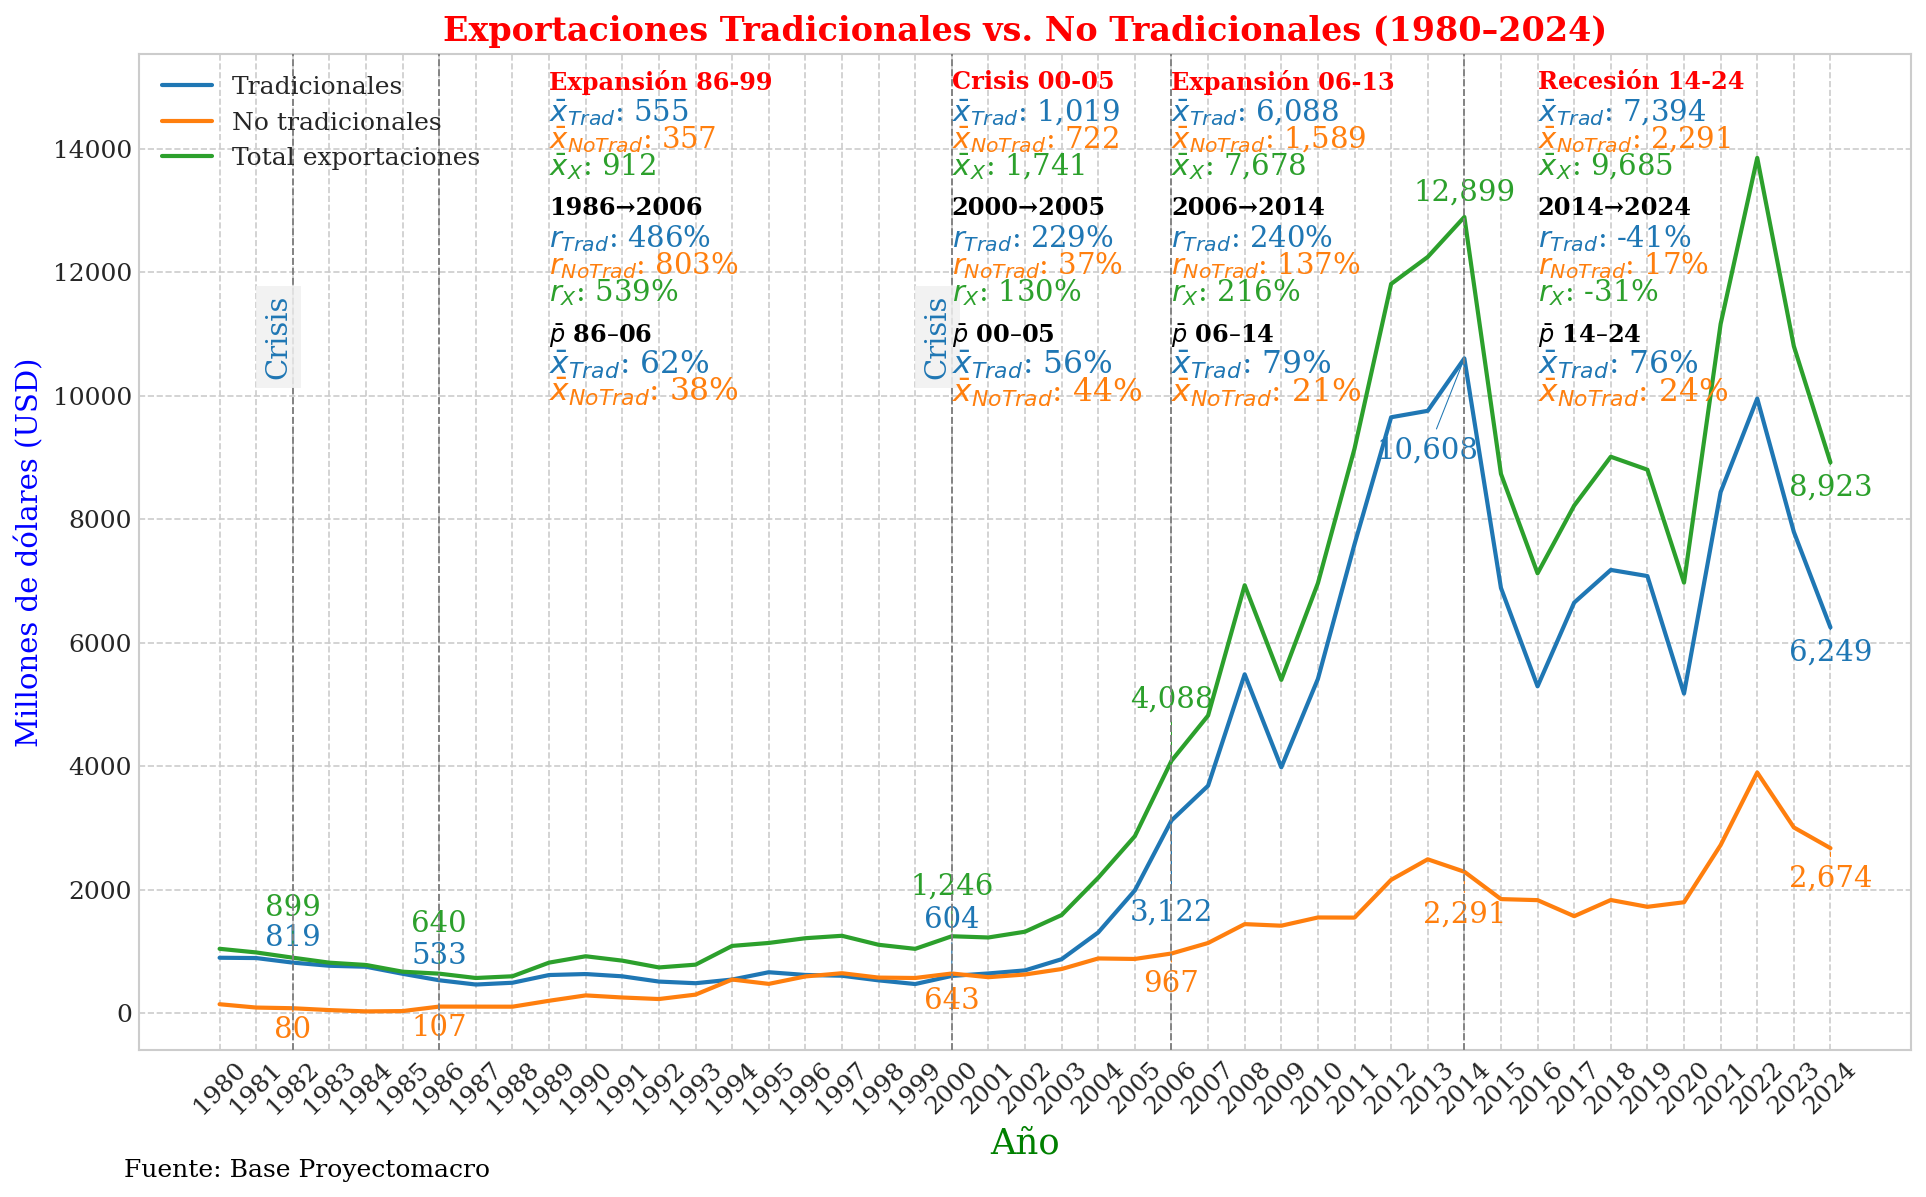

In [5]:
# ───────────────────────────── 0. IMPORTS Y CONFIGURACIÓN GLOBAL ─────────────────────────────
import os, sys, sqlite3
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../'))                 # utilidades propias
from graficos_utils import *
from config import *                                   # CYCLES, hitos_v, annot_years, periodos_tasas …

INDICADOR  = "exportaciones_trad_vs_notrad"
OUTPUT_DIR = f"../../../../assets/tesis/serie_completa/{INDICADOR}"
os.makedirs(OUTPUT_DIR, exist_ok=True)

set_style()                                            # estilo uniforme de toda la tesis

# ───────────────────────────── 1. CARGA DE DATOS ─────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df = (pd.read_sql("SELECT * FROM exportaciones_tradicionales_no_tradicionales", conn)
            .set_index("año")
            .sort_index())

df["exportaciones"] = df["tradicionales"] + df["no_tradicionales"]

# ──────────────── 2. DEFINICIÓN DE COMPONENTES, COLORES Y ABREVIATURAS ────────────────
componentes = [
    ("tradicionales",    "Tradicionales"),
    ("no_tradicionales", "No tradicionales"),
    ("exportaciones",    "Total exportaciones"),
]
cols_componentes = [c for c, _ in componentes]

cmap   = plt.get_cmap("tab10")
colors = {col: cmap(i) for i, (col, _) in enumerate(componentes)}
abbr   = {"tradicionales":"Trad", "no_tradicionales":"NoTrad", "exportaciones":"X"}

# ──────────────── 3. PREPARACIÓN DE CICLOS, ANOTACIONES Y PERÍODOS ────────────────
cycles        = adjust_cycles(df, CYCLES)                       # de config.py
annot_years   = [1982, 1986, 2000, 2006, 2014, 2024]
periodos      = adjust_periods(df, periodos_tasas)              # para growth-arrows
cycle_stats   = {n: df.loc[slice_, cols_componentes].mean().to_dict()
                 for n, slice_ in cycles.items()}

# ──────────────── 4. OFFSETS Y POSICIONAMIENTOS ────────────────
hitos_offsets = {a:0.80 for a in hitos_v}

annotation_offsets = {
    "exportaciones":    {1982:(0,800),1986:(0,800),2000:(0,800),
                         2006:(0,1000),2014:(0,400),2024:(0,-400)},
    "tradicionales":    {1982:(0,400),1986:(0,400),2000:(0,900),
                         2006:(0,-1500),2014:(-1,-1500),2024:(0,-400)},
    "no_tradicionales": {1982:(0,-350),1986:(0,-350),2000:(0,-450),
                         2006:(0,-500),2014:(0,-700),2024:(0,-500)},
}

medias_offsets = {
    "Expansión 86-99": (1989, 1.05),
    "Crisis 00-05":    (2000, 1.05),
    "Expansión 06-13": (2006, 1.05),
    "Recesión 14-24":  (2016, 1.05),
}

tasas_offsets = {
    "1986-2006": (1989, 0.91),
    "2000-2005": (2000, 0.91),
    "2006-2014": (2006, 0.91),
    "2014-2024": (2016, 0.91),
}

participation_offsets = {
    "1986-2006": (1989, 0.77),
    "2000-2005": (2000, 0.77),
    "2006-2014": (2006, 0.77),
    "2014-2024": (2016, 0.77),
}

# ───────────────────────────── 5. GENERACIÓN DE LA GRÁFICA ─────────────────────────────
fig, ax = init_base_plot(
    df=df,
    series=componentes,                # helper mantiene arg. 'series', recibe la lista componentes
    colors=colors,
    title=f"Exportaciones Tradicionales vs. No Tradicionales ({df.index[0]}–{df.index[-1]})",
    xlabel="Año",
    ylabel="Millones de dólares (USD)",
    source_text="Fuente: Base Proyectomacro",
    legend_ncol=1
)

add_hitos(ax, df.index, hitos_v, hitos_offsets, line_kwargs={"linewidth":0.9})

# medias de ciclo
add_cycle_means_multi(
    ax, cycle_stats, medias_offsets,
    abbr, colors, line_spacing=ax.get_ylim()[1]*0.03
)

# anotaciones puntuales
add_year_value_annotations(
    ax, df, annot_years,
    cols_componentes, annotation_offsets, colors, arrow_lw=0.5
)

# tasas de crecimiento por periodo
periodos_growth = [(1986,2006),(2000,2005),(2006,2014),(2014,2024)]
add_period_growth_annotations_multi(
    ax, df, periodos_growth,
    cols_componentes, tasas_offsets, colors, abbr
)

# cuadros de participación
add_participation_cycle_boxes(
    ax, df, periodos_growth,
    ["tradicionales","no_tradicionales"],      # componentes parciales
    "exportaciones",                           # total
    participation_offsets,
    abbr_map=abbr, colors={c:colors[c] for c in ["tradicionales","no_tradicionales"]}
)

ax.set_ylim(-600, ax.get_ylim()[1] + 1000)


plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "exportaciones_tradicionales_no_tradicionales.png"), dpi=300)
plt.show()
